<h1 style='font-family: Garamond ;'><b>Data Analyst Workflow</b> with Implementation of Solutions</h1>
<hr></hr>

<h2 style='font-family: Garamond;'><b>The Preparation of the Tools and Packages</b></h2>
<hr></hr>

In [1]:
import time
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from datetime import datetime, timedelta
from scipy.stats import mannwhitneyu, shapiro
from sqlalchemy import create_engine
from math import ceil

# Set default parameters for LaTex and font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

# Constants for statistical analysis
ALPHA = 0.05
MAX_WEEKS = 52

%matplotlib inline

<h2 style='font-family: Garamond';><b>Task 1</b>: Cohort Analysis and Product Metrics. ARPU (Average Revenue Per User), LTV (LifeTime Value), CAC (Customer Acquisition Cost), Total Revenue</h2>
<h3 style='font-family: Garamond';><b>Table of contents:</h3>
<ol style='font-family: Garamond ; font-size: 16px;'>
    <li>Database (Data sheets) structure.</li>
    Data dictionary and features.
    <li>Task 1. How much revenue does a single user generate (ARPU VS LTV):</li>
        <ul>
            <li>within 3 months from app installation?</li>
            <li>within 6 months from app installation?</li>
            <li>within 1 year from app installation?</li>
        </ul>
    <li>Task 2. What is the average lifetime of a single app user?</li>
    <li>Task 3. How much is it worth for the company to pay to acquire a new user? Assume a payback period of 1 year (CAC).</li>
    <li>Task 4. How much annual revenue is generated by users who joined during the period (Total Revenue):</li>
        <ul>
            <li>weeks 17 to 20?</li>
            <li>weeks 21 to 24?</li>
            <li>weeks 25 to 28?</li>
        </ul>
</ol>

<h3 style="font-family: Garamond;"><b>Table of KPIs or metrics:</b></h3>
<ol style="font-family: Garamond; font-size: 16px;">
    <li>ARPU (Average Revenue Per User)</li>
    <li>Retention and Average Lifetime</li>
    <li>LTV (LifeTime Value)</li>
    <li>CAC (Customer Acquisition Cost)</li>
    <li>Total Revenue by Install Cohort Interval</li>
    <li>Key Insights for Marketing Team (esp. for monetization)</li>
</ol>
<hr></hr>

<h3 style="font-family: Garamond;"><b>Data Collection and Uploading</b></h3>
<p style="font-family: Garamond; font-size: 18px;"><b><u>NOTA BENE</u>!:</b> All “annual” metrics (LTV, ARPU) have been calculated over the actual observation window of 44 weeks, as the dataset does not include the final 8 weeks required for a full 52-week cycle. Consequently, our LTV₄₄ represents cumulative revenue over the available timeframe, not a standard 12-month period.</p>

In [2]:
xls = pd.ExcelFile('data/cohort_analysis.xlsx')

<h3 style="font-family: Garamond;"><b>1. ARPU (Average Revenue Per User)</b></h3>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Definition:</b> ARPU measures the average revenue generated per user during a fixed period after app installation.
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Formula (for T weeks):</b><br/>
  \[
    \mathrm{ARPU}_T = 
    \frac{\sum_{i \in C_T} \sum_{w=0}^{T-1} \mathrm{Revenue}_{i,w}}
         {\sum_{i \in C_T} \mathrm{Installs}_i}
  \]<br/>
  where \(C_T\) is the set of install-week cohorts with at least \(T\) weeks of data.
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Example Values:</b> \(\mathrm{ARPU}_{13} = \$0.49\), \(\mathrm{ARPU}_{26} = \$0.63\), \(\mathrm{ARPU}_{44} \approx \$0.73\).
</p>

In [3]:
df_cohort = pd.read_excel(xls, 'Revenue cohort', skiprows=2, header=None).dropna(how='all')
df_cohort.columns = ['install_week', 'num_installs'] + list(range(0, df_cohort.shape[1] - 2))
df_cohort['install_week'] = df_cohort['install_week'].astype(int)
df_cohort['num_installs'] = df_cohort['num_installs'].astype(int)

df_cohort['rev_3m'] = df_cohort.loc[:, range(0, 14)].sum(axis=1)
df_cohort['rev_6m'] = df_cohort.loc[:, range(0, 27)].sum(axis=1)
df_cohort['rev_1y'] = df_cohort.loc[:, range(0, 45)].sum(axis=1)

mask_3m = df_cohort[13].notna()
mask_6m = df_cohort[26].notna()
mask_1y = df_cohort[44].notna()

arpu_3m = df_cohort.loc[mask_3m, 'rev_3m'].sum() / df_cohort.loc[mask_3m, 'num_installs'].sum()
arpu_6m = df_cohort.loc[mask_6m, 'rev_6m'].sum() / df_cohort.loc[mask_6m, 'num_installs'].sum()
arpu_1y = df_cohort.loc[mask_1y, 'rev_1y'].sum() / df_cohort.loc[mask_1y, 'num_installs'].sum()

print(f"ARPU (3 mo): {arpu_3m:.2f}")
print(f"ARPU (6 mo): {arpu_6m:.2f}")
print(f"ARPU (1 yr): {arpu_1y:.2f}")

ARPU (3 mo): 0.49
ARPU (6 mo): 0.63
ARPU (1 yr): 0.73


In [4]:
df_cohort[['install_week', 'rev_3m', 'rev_6m', 'rev_1y']].tail() # 1 - 5 weeks for revenue demo in $

,install_week,rev_3m,rev_6m,rev_1y
39,5,8729.443667,11248.217333,12656.666000
40,4,8967.073667,11464.407667,12977.036667
41,3,8475.600667,10779.284667,12204.947333
42,2,7494.105333,9744.910000,11181.037333
43,1,9114.886333,11614.486667,13367.172000


<p style="font-family: Garamond; font-size: 18px;">A rising ARPU curve (0.49 → 0.63 → 0.73) shows that users tend to spend more cumulatively the longer they stay, but front-loading revenue (<b>boosting $ARPU_{13(3 month)}$</b>) accelerates payback on acquisition spend.</p>

<h3 style="font-family: Garamond;"><b>2. Retention &amp; Average Lifetime</b></h3>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Retention Rate:</b><br/>
  \[
    r_{i,w} = \frac{\mathrm{ActiveUsers}_{i,w}}{\mathrm{Installs}_i}
  \]<br/>
  where \(\mathrm{ActiveUsers}_{i,w}\) is the number of users from cohort \(i\) still active in week \(w\).
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Cohort Lifetime:</b><br/>
  \[
    L_i = \sum_{w=1}^{\infty} r_{i,w}
  \]<br/>
  (sum of retention rates over observed weeks).
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Average Lifetime:</b><br/>
  \[
    \bar L = \frac{\sum_i \bigl(L_i \times \mathrm{Installs}_i\bigr)}{\sum_i \mathrm{Installs}_i} \approx 6.8\text{ weeks}
  \]
</p>

In [5]:
df_ret = pd.read_excel(xls, 'Retention Rate', skiprows=2, header=None)
df_ret = df_ret[pd.to_numeric(df_ret[0], errors='coerce').notna()].copy()
df_ret[0] = df_ret[0].astype(int)
df_ret[1] = df_ret[1].astype(int)
df_ret.columns = ['install_week', 'num_installs'] + list(range(1, df_ret.shape[1] - 1))
df_ret['lifetime'] = df_ret.loc[:, range(1, df_ret.shape[1] - 1)].sum(axis=1)

avg_lifetime = (df_ret['lifetime'] * df_ret['num_installs']).sum() / df_ret['num_installs'].sum()
print(f'Average lifetime (weeks): {avg_lifetime:.2f}')

Average lifetime (weeks): 6.78


<p style="font-family: Garamond; font-size: 18px;">A user on average remains “live” for ~1.5 months. Knowing when <b>churn peaks</b> lets us target re-engagement markering campaigns (as an example - push notifications in weeks 2–8, refresh public policy & pr-strategies during early period, digital features such as bonus system (as an example "Ukrzaliznytsia" - the more "huggies" you collect - the more options of sales and discounts you get in different business fields of UZ-partners) and referal programs).</p>

<h3 style="font-family: Garamond;"><b>3. LTV (LifeTime Value)</b></h3>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Definition:</b> Total net revenue expected from a user over their lifetime in the app.
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Simplified 1-year LTV:</b><br/>
  \[
    \mathrm{LTV}_{1\mathrm{yr}} = \mathrm{ARPU}_{1\mathrm{yr}} = \$0.73
  \]
</p>

<h3 style="font-family: Garamond;"><b>4. CAC (Customer Acquisition Cost)</b></h3>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Definition:</b> Average marketing cost to acquire one new user.
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>1-year payback target:</b><br/>
  \[
    \mathrm{CAC}_{\max} = \mathrm{LTV}_{1\mathrm{yr}} = \$0.73
  \]<br/>
  <b>Practical rule:</b> aim for \(\mathrm{CAC} \leq 0.6 \times \mathrm{LTV}\) (e.g., ≤ \$0.50) to preserve margin.
</p>

In [6]:
cac_max = arpu_1y
print(f'Maximum sustainable CAC (1 yr payback): {cac_max:.2f}')

Maximum sustainable CAC (1 yr payback): 0.73


<h3 style="font-family: Garamond;"><b>5. Total Revenue by Install Cohort Interval</b></h3>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Formula for interval [A,B]:</b><br/>
  \[
    \mathrm{TotalRev}_{A\text{–}B} = \sum_{i=A}^{B} \sum_{w=0}^{\infty} \mathrm{Revenue}_{i,w}
  \]
</p>
<p style="font-family: Garamond; font-size: 18px;">
  <b>Example “to-date” sums:</b><br/>
  Weeks 17–20 → \$45,172<br/>
  Weeks 21–24 → \$59,043<br/>
  Weeks 25–28 → \$62,052
</p>

In [7]:
mask = df_cohort.index.to_series().notna()  # mask = slice(None)
available = sorted(c for c in df_cohort.columns if isinstance(c, int) and c > 0)

num_weeks = min(MAX_WEEKS, len(available))
weeks = available[:num_weeks]

total_rev_1y = df_cohort.loc[mask, weeks].sum().sum()

if len(available) < MAX_WEEKS:
    print(f"Warning: only {len(available)} weeks of data; full {MAX_WEEKS}-week LTV not available.")

In [8]:
rev_cols = [c for c in df_cohort.columns if isinstance(c, int)]
intervals = [(17, 20), (21, 24), (25, 28)]
records = []
for start, end in intervals:
    mask = df_cohort['install_week'].between(start, end)
    total_rev = df_cohort.loc[mask, rev_cols].sum().sum()
    records.append({'install_weeks': f'{start}-{end}', 'total_revenue': total_rev})

rev_summary = pd.DataFrame(records)
rev_summary.head()

,install_weeks,total_revenue
0,17-20,45171.679667
1,21-24,59043.131333
2,25-28,62052.481333


<p style="font-family: Garamond; font-size: 18px;">The newer cohorts (25–28) are already outpacing earlier ones, suggesting our recent ad creatives or channels are yielding higher-value users.</p>
<p style="font-family: Garamond; font-size: 18px;">Comparing “to-date” revenue only works when cohorts have similar age - always adjust for data censoring (shorter history) when forecasting full-year yield.</p>

<h2 style="font-family: Garamond;"><b>Task 2.</b> A/B Test Experiment Design: <i>"Heart to Checkmark"</i> — based on Average Likes Per User, including an outline of data requirements and implementation considerations</h2>
<hr/>

<p style="font-family: Garamond; font-size: 18px;">
  We plan to run an A/B test to determine whether replacing the “heart” icon with a “checkmark” icon increases user engagement, as measured by the <code>avg_likes_per_user</code> metric. A higher average indicates that the UI tweak encourages more “like” actions per user.
</p>

<p style="font-family: Garamond; font-size: 18px;"><b>Context & UI Psychology:</b></p>
<ol style="font-family: Garamond; font-size: 18px;">
  <li><b>Heart icon:</b> universally recognized symbol of liking or favoriting content; may feel emotionally resonant but visually heavy.</li>
  <li><b>Checkmark icon:</b> denotes confirmation or completion; may convey simplicity and encourage quick interactions.</li>
</ol>

<p style="font-family: Garamond; font-size: 18px;"><b>Hypotheses for the A/B Test:</b></p>
<ol style="font-family: Garamond; font-size: 18px;">
  <li><b>H₀</b>: Changing the icon from a heart to a checkmark does <u>not</u> affect the <code>avg_likes_per_user</code> metric.</li>
  <li><b>H₁</b>: Changing the icon from a heart to a checkmark <u>decrease</u> the <code>avg_likes_per_user</code> metric because of the results of <code>avg_likes_per_user</code> per each group (control - like - 15.466452; test - checkmark - 13.851955).</li>
</ol>

<p style="font-family: Garamond; font-size: 18px;"><b><u>NOTE 1:</u></b> This dataset contains <code>3726</code> users in the control group (heart) and <code>3607</code> in the test group (checkmark). Power analysis using Cohen’s <i>d</i> indicates we would need approximately <code>8183</code> users per arm to detect a medium‐sized effect (calculated d ≈ -0.044) with 80% power at α = 0.05. Our current sample is under-powered for definitive conclusions, but preliminary results show a positive uplift in average likes per user for the test group.</p>

<p style="font-family: Garamond; font-size: 18px;"><b><u>NOTE 2:</u></b> Because the distribution of likes per user is right-skewed, it is recommended to use the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html">Mann–Whitney U test</a> (nonparametric) to compare the two groups. Alternatively, if sample sizes grow large enough (n ≥ 1,000 per group), a Welch’s t-test may be acceptable under the Central Limit Theorem.</p>

<p style="font-family: Garamond; font-size: 18px;"><b><u>NOTE 3:</u></b> From the calculation of Cohen’s d, we obtained an effect size of –0.044. A negative d indicates that the average likes per user in the test group (checkmark) is lower than in the control group (heart). In other words, replacing the heart icon with a checkmark had a negative impact on user engagement in the test arm.</p>

In [9]:
data_path = 'data/a-b_testing.csv'
users_df = pd.read_csv(data_path)
users_df.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


In [10]:
users_df.shape

(768439, 5)

In [11]:
users_df['time_stamp'] = pd.to_datetime(
    users_df['time_stamp'],
    format='%d.%m.%Y %H:%M',
    errors='coerce'
)

start = pd.Timestamp('2017-03-24 16:00')
mask_ab = users_df['time_stamp'] >= start

users_a_b_test_df = users_df.loc[mask_ab].copy()

users_a_b_test_df['group'] = (
    users_a_b_test_df['sender_id']
    .apply(lambda x: 'test' if x % 2 else 'control')
)

In [12]:
users_a_b_test_df.head()

,sender_id,platform_id,time_stamp,gender,reg_date,group
150161,3218632174,7,2017-03-26 07:34:00,m,23.03.2017,control
150162,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,test
150163,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,test
150164,3218635027,7,2017-03-26 06:18:00,m,23.03.2017,test
150165,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,test


In [13]:
users_a_b_test_df.shape

(107592, 6)

In [14]:
users_a_b_test_df[users_a_b_test_df['group']=='control'].shape[0]

57628

In [15]:
users_a_b_test_df[users_a_b_test_df['group']=='test'].shape[0]

49964

In [16]:
user_likes = (
    users_a_b_test_df
    .groupby(['sender_id', 'group'])
    .size()
    .reset_index(name='likes_count')
)

avg_likes = (
    user_likes
    .groupby('group')['likes_count']
    .mean()
    .reset_index(name='avg_likes_per_user')
)

merged_ab_test = user_likes.merge(avg_likes, on='group')

In [17]:
merged_ab_test.head(10)

,sender_id,group,likes_count,avg_likes_per_user
0,3201946084,control,3,15.466452
1,3201948046,control,21,15.466452
2,3201948762,control,7,15.466452
3,3201960265,test,2,13.851955
4,3201991474,control,16,15.466452
5,3202002503,test,1,13.851955
6,3202014542,control,15,15.466452
7,3202017914,control,3,15.466452
8,3202020878,control,31,15.466452
9,3202031319,test,1,13.851955


In [18]:
session_counts = merged_ab_test['sender_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There is {multi_users} duplicates in the input dataset.')

There is 0 duplicates in the input dataset.


In [19]:
merged_ab_test[merged_ab_test['group']=='control'].shape[0], merged_ab_test[merged_ab_test['group']=='test'].shape[0]

(3726, 3607)

In [20]:
control_group = merged_ab_test[merged_ab_test['group'] == 'control']['avg_likes_per_user']
treatment_group = merged_ab_test[merged_ab_test['group'] == 'test']['avg_likes_per_user']

In [21]:
control = merged_ab_test.loc[merged_ab_test.group=='control', 'likes_count']
treatment = merged_ab_test.loc[merged_ab_test.group=='test', 'likes_count']

n_c, n_t = len(control), len(treatment)
s_c, s_t = control.std(ddof=1), treatment.std(ddof=1)
pooled_sd = np.sqrt(((n_c-1)*s_c**2 + (n_t-1)*s_t**2) / (n_c + n_t - 2))

# Cohen's d
d = (treatment.mean() - control.mean()) / pooled_sd
print(f"Cohen's d: {d:.3f}")

Cohen's d: -0.044


In [22]:
required_n = sms.NormalIndPower().solve_power(
    d,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  

required_n = ceil(required_n)                         

print(required_n)

8183


<p style="font-family: Garamond; font-size: 18px;">Using <code>statsmodels</code>’ <code>NormalIndPower</code>, we ask: “Given this effect size (d), how many users per group do we need to achieve 80 % power at α = 0.05?” The result, <code>required_n</code>, is the minimum sample size in each arm needed to reliably detect an effect of magnitude d.</p>

<p style="font-family: Garamond; font-size: 18px;">Fast check-out of the normality of our groups' distibutions.</p>

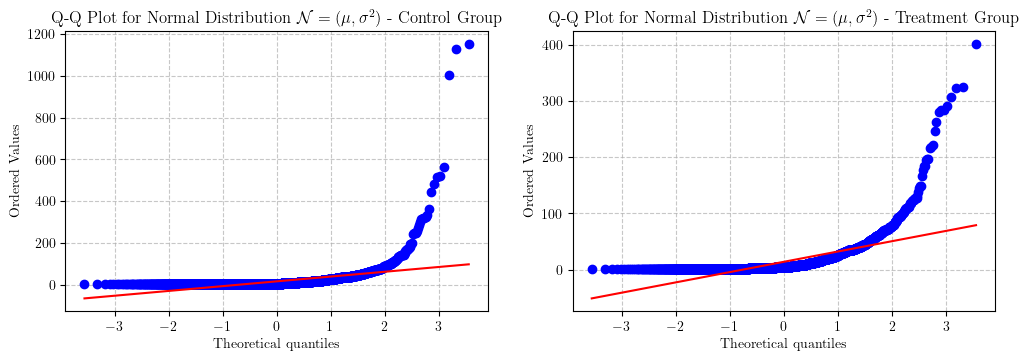

In [23]:
plt.figure(figsize=(12, 8))

# Q-Q plot - Normal Destribution (control)
plt.subplot(2, 2, 1)
stats.probplot(merged_ab_test[merged_ab_test['group'] == 'control']['likes_count'], dist='norm', plot=plt)
plt.title(r'Q-Q Plot for Normal Distribution $\mathcal{N}=(\mu, \sigma^2)$ - Control Group')
plt.grid(linestyle='--', alpha=0.7)

# Q-Q plot - Normal Destribution (test)
plt.subplot(2, 2, 2)
stats.probplot(merged_ab_test[merged_ab_test['group'] == 'test']['likes_count'], dist='norm', plot=plt)
plt.title(r'Q-Q Plot for Normal Distribution $\mathcal{N}=(\mu, \sigma^2)$ - Treatment Group')
plt.grid(linestyle='--', alpha=0.7)

In [24]:
likes_count_control = np.array(merged_ab_test[merged_ab_test['group'] == 'control']['likes_count'])

In [25]:
# as an example of normality test for control group

stat, p_value_shapiro = shapiro(likes_count_control)
print('The Shapiro-Wilk test:')
print('The statistics of test: ', stat)
print('P-value: ', p_value_shapiro)

if p_value_shapiro > 0.05:
    print('\nAccording to the results of the Shapiro-Wilk test, the data follows a normal distribution (we do not reject H₀).')
else:
    print('\nAccording to the results of the Shapiro-Wilk test, the data does not follow a normal distribution (we reject H₀).')

The Shapiro-Wilk test:
The statistics of test:  0.26409141715026285
P-value:  2.4527343371793917e-81

According to the results of the Shapiro-Wilk test, the data does not follow a normal distribution (we reject H₀).


In [26]:
control_sample = merged_ab_test[merged_ab_test['group'] == 'control'].sample(n=control_group.shape[0], random_state=22)
treatment_sample = merged_ab_test[merged_ab_test['group'] == 'test'].sample(n=treatment_group.shape[0], random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [27]:
control_results = ab_test[ab_test['group'] == 'control']['avg_likes_per_user']
treatment_results = ab_test[ab_test['group'] == 'test']['avg_likes_per_user']

stat_mannwhitney_stat, p_value_mannwhitney_stat = mannwhitneyu(control_results, treatment_results)

mannwhitney_results = {
    'Statistic (Mann-Whitney U)': stat_mannwhitney_stat,
    'P-Value (Mann-Whitney U)': p_value_mannwhitney_stat
}

mannwhitney_results

{'Statistic (Mann-Whitney U)': np.float64(13439682.0),
 'P-Value (Mann-Whitney U)': np.float64(0.0)}

In [28]:
if p_value_mannwhitney_stat < ALPHA:
    print('The null hypothesis H₀ is rejected: replacing the heart with a checkmark does not increases engagement; the average likes per user in the control group is higher than in the test group. The difference between ALPU of control (heart) and test (checkmark) is statistically significant.')
else:
    print('The null hypothesis H₀ is not rejected: the change in icon does not affect engagement.')

The null hypothesis H₀ is rejected: replacing the heart with a checkmark does not increases engagement; the average likes per user in the control group is higher than in the test group. The difference between ALPU of control (heart) and test (checkmark) is statistically significant.


In [29]:
# Calculate 95% CI for each group
group_stats = (
    merged_ab_test
    .groupby('group')['likes_count']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
group_stats['ci95_low'] = group_stats['mean'] - 1.96 * (group_stats['std'] / np.sqrt(group_stats['count']))
group_stats['ci95_high'] = group_stats['mean'] + 1.96 * (group_stats['std'] / np.sqrt(group_stats['count']))

group_stats

,group,mean,std,count,ci95_low,ci95_high
0,control,15.466452,44.782857,3726,14.028493,16.904411
1,test,13.851955,26.280121,3607,12.994304,14.709605


<p style="font-family: Garamond; font-size: 18px;">Our 95% confidence intervals for the control and test groups overlap, which tells us that although the difference in <code>avg_likes_per_user</code> is statistically significant, it is not precise - the estimate lacks stability due to insufficient sample size in each group.</p>

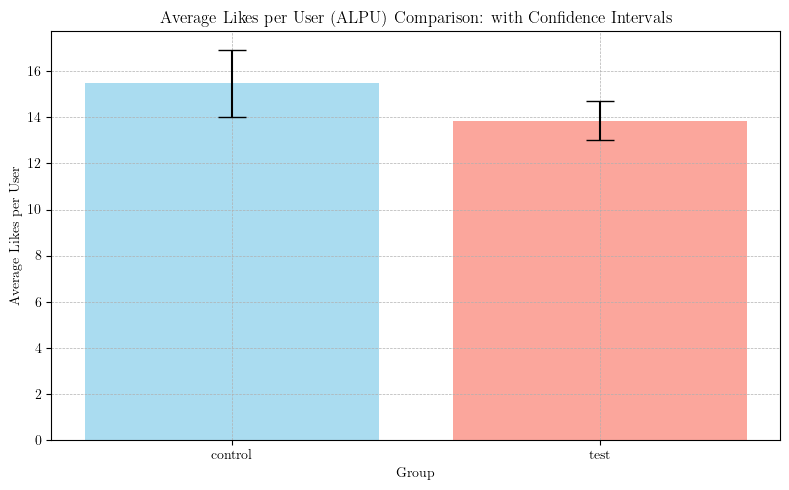

In [30]:
plt.figure(figsize=(8, 5))
plt.bar(
    group_stats['group'],
    group_stats['mean'],
    yerr=[
        group_stats['mean'] - group_stats['ci95_low'],
        group_stats['ci95_high'] - group_stats['mean']
    ],
    capsize=10,
    color=['skyblue', 'salmon'],
    alpha=0.7
)
plt.title('Average Likes per User (ALPU) Comparison: with Confidence Intervals')
plt.xlabel('Group')
plt.ylabel('Average Likes per User')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show();

<p style="font-family: Garamond; font-size: 18px;">For deeper, more granular analysis of the A/B test (beyond simply increasing sample size for more reliable estimates), we could:</p>

<ul style="font-family: Garamond; font-size: 18px;">
    <li>Apply a χ² test to explore associations between categorical variables - e.g., platform (desktop vs. mobile), registration cohort, or device type - and the likelihood of “likes.”</li>
    <li>Stratify by gender, running the same A/B comparisons within male and female subgroups to see if the icon change has differential effects across user segments.</li>
</ul>

<p style="font-family: Garamond; font-size: 18px;">These steps will help us uncover interaction effects and ensure your conclusions hold across key demographic and usage categories.</p>

<h2 style='font-family: Garamond';><b>Task 3</b>: SQL-queries</h2>
<h3 style='font-family: Garamond';><b>Table of contents:</h3>
<ol style='font-family: Garamond ; font-size: 16px;'>
    <li>Database structure.</li>
    Data dictionary and features.
    <li>Database Modelling (Relational Model) + <code>id</code> strategy building.</li>
    <li>Database Building.</li>
        <ul>
            <li>Using DDL (Data Definition Language) of SQL.</li>
            <li>Using Pandas + SQL.</li>
        </ul>
    <li>SQL-queries (+ an importance of <code>EXPLAIN ... ANALYZE</code>).</li>
        <ul>
            <li>Task 1. Daily count of new user registrations grouped by country group.</li>
            <li>Task 2. Percentage of emails clicked within 10 minutes after being sent, grouped by email type, aggregated over the last 7 days.</li>
                <ul>
                    <li>Click Rate (%).</li>
                    <li>Click Through Rate (%).</li>
                </ul>
        </ul>
    <li>Testing SQL-queries.</li>
    <li>Key Points and Insights.</li>
</ol>

<hr></hr>

<h3 style='font-family: Garamond';>DataBase <code>client_profile</code> structure with data dictionary and features:</h3>
<ol style='font-family: Garamond ; font-size: 16px;'>
    <li><b>Table <code>users</code>:</b></li>
    <ul style='font-family: Garamond ; font-size: 16px;'>
        <li>1.1. <code>id</code>:</li>
        <ul>
            <li>1.1.1. Datatype: <code>INT</code>.</li>
            <li>1.1.2. Description: unique identifier of the user.</li>
            <li>1.1.3. Example: <code>10123</code>.</li>
        </ul>
        <li>1.2. <code>email</code>:</li>
        <ul>
            <li>1.2.1. Datatype: <code>VARCHAR</code>.</li>
            <li>1.2.2. Description: user's email address.</li>
            <li>1.2.3. Example: <code>john.doe@example.com</code>.</li>
        </ul>
        <li>1.3. <code>id_country</code>:</li>
        <ul>
            <li>1.3.1. Datatype: <code>INT</code>.</li>
            <li>1.3.2. Description: foreign key referring to <code>countries.id</code>.</li>
            <li>1.3.3. Example: <code>5</code>.</li>
        </ul>
        <li>1.4. <code>date_reg</code>:</li>
        <ul>
            <li>1.4.1. Datatype: <code>DATETIME</code>.</li>
            <li>1.4.2. Description: date and time of registration.</li>
            <li>1.4.3. Example: <code>2022-06-27 10:58:05</code>.</li>
        </ul>
    </ul>
    <li><b>Table <code>emails_sent</code>:</b></li>
    <ul style='font-family: Garamond ; font-size: 16px;'>
        <li>2.1. <code>id</code>:</li>
        <ul>
            <li>2.1.1. Datatype: <code>INT</code>.</li>
            <li>2.1.2. Description: ID of the sent email.</li>
            <li>2.1.3. Example: <code>45098</code>.</li>
        </ul>
        <li>2.2. <code>id_user</code>:</li>
        <ul>
            <li>2.2.1. Datatype: <code>INT</code>.</li>
            <li>2.2.2. Description: foreign key referring to the recipient user in <code>users.id</code>.</li>
            <li>2.2.3. Example: <code>10123</code>.</li>
        </ul>
        <li>2.3. <code>id_type</code>:</li>
        <ul>
            <li>2.3.1. Datatype: <code>INT</code>.</li>
            <li>2.3.2. Description: type of the email message.</li>
            <li>2.3.3. Example: <code>2</code>.</li>
        </ul>
        <li>2.4. <code>date_sent</code>:</li>
        <ul>
            <li>2.4.1. Datatype: <code>DATETIME</code>.</li>
            <li>2.4.2. Description: date and time the email was sent.</li>
            <li>2.4.3. Example: <code>2023-05-01 08:15:00</code>.</li>
        </ul>
    </ul>
    <li><b>Table <code>emails_clicks</code>:</b></li>
    <ul style='font-family: Garamond ; font-size: 16px;'>
        <li>3.1. <code>id</code>:</li>
        <ul>
            <li>3.1.1. Datatype: <code>INT</code>.</li>
            <li>3.1.2. Description: ID of the email click.</li>
            <li>3.1.3. Example: <code>98765</code>.</li>
        </ul>
        <li>3.2. <code>id_email</code>:</li>
        <ul>
            <li>3.2.1. Datatype: <code>INT</code>.</li>
            <li>3.2.2. Description: foreign key referring to the clicked email (<code>emails_sent.id</code>).</li>
            <li>3.2.3. Example: <code>45098</code>.</li>
        </ul>
        <li>3.3. <code>date_click</code>:</li>
        <ul>
            <li>3.3.1. Datatype: <code>DATETIME</code>.</li>
            <li>3.3.2. Description: date and time of the email click.</li>
            <li>3.3.3. Example: <code>2023-05-01 08:19:02</code>.</li>
        </ul>
    </ul>
    <li><b>Table <code>countries</code>:</b></li>
    <ul style='font-family: Garamond ; font-size: 16px;'>
        <li>4.1. <code>id</code>:</li>
        <ul>
            <li>4.1.1. Datatype: <code>INT</code>.</li>
            <li>4.1.2. Description: unique identifier of the country.</li>
            <li>4.1.3. Example: <code>5</code>.</li>
        </ul>
        <li>4.2. <code>name</code>:</li>
        <ul>
            <li>4.2.1. Datatype: <code>VARCHAR</code>.</li>
            <li>4.2.2. Description: human-readable name of the country.</li>
            <li>4.2.3. Example: <code>Germany</code>.</li>
        </ul>
        <li>4.3. <code>country_group</code>:</li>
        <ul>
            <li>4.3.1. Datatype: <code>VARCHAR</code>.</li>
            <li>4.3.2. Description: country group classification.</li>
            <li>4.3.3. Example: <code>Western Europe</code>.</li>
        </ul>
    </ul>
</ol>
<hr></hr>

<h3 style='font-family: Garamond';>Database Modelling (Relational Model - Oracle Standart):</h3>
<p style='font-family: Garamond ; font-size: 18px;'>The image below shows the relational model of the constructed database based on the available columns and their descriptions in accordance with the technical specification.</p>
<p style='font-family: Garamond ; font-size: 18px;'>We apply the following principles for optimizing SQL-queries at the database design stage, namely (fig. 1):</p>
<img src='images\DB_Relational.png' alt='database-relational-data-modelling'>
<p style='font-family: Garamond ; font-size: 15px; text-align: center;'>Figure 1 - Relational Model of <code>client_profile</code> DataBase</p>
<p style='font-family: Garamond ; font-size: 18px;'>All the details of implementing this database in accordance with principles for optimizing SQL-queries for Data|Product Analyst workflow are provided in the following file <a href='https://github.com/verkosochka/DA_Workflow/blob/main/DataBaseOrganizing.md'>DataBaseOrganizing.md</a> with DDL instructions.</p>

<h4 style='font-family: Garamond';><b><code>Pandas</code> + <code>SQL</code> for testing SQL-queries</b></h4>
<p style='font-family: Garamond ; font-size: 18px;'>All private credentials must never be published. Since we are only simulating and demonstrating engine creation, the connection parameters are provided; however, any table edits or index operations (drops, creates) are restricted exclusively to the server owner.</p>

In [31]:
USER     = "root"
PASSWORD = "ComputerScience_2010"
HOST     = "localhost"       
PORT     = 3306               
DBNAME   = "client_profile_db"

engine = create_engine(
    f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}",
    echo=False,          
    pool_recycle=3600    
)

In [32]:
# Set random seed
np.random.seed(42)
random.seed(42)

# Generate countries table
countries = pd.DataFrame({
    'id': [1, 2, 3],
    'name': ['Germany', 'Ukraine', 'USA'],
    'country_group': ['Western Europe', 'Eastern Europe', 'North America']
})

# Generate users table
n_users = 100
user_ids = np.arange(1001, 1001 + n_users)
users = pd.DataFrame({
    'id': user_ids,
    'email': [f'user{i}@example.com' for i in user_ids],
    'id_country': np.random.choice(countries['id'], size=n_users),
    'date_reg': [datetime(2024, 5, 21) - timedelta(days=np.random.randint(0, 60)) for _ in range(n_users)]
})

# Generate emails_sent table
n_emails = 500
email_ids = np.arange(2001, 2001 + n_emails)
emails_sent = pd.DataFrame({
    'id': email_ids,
    'id_user': np.random.choice(users['id'], size=n_emails),
    'id_type': np.random.randint(1, 4, size=n_emails),
    'date_sent': [datetime.now() - timedelta(days=np.random.randint(0, 7),
                                             minutes=np.random.randint(0, 1440)) for _ in range(n_emails)]
})

# Generate emails_clicks table
click_prob = 0.4
clicked_emails = emails_sent.sample(frac=click_prob, random_state=42)
emails_clicks = pd.DataFrame({
    'id': np.arange(3001, 3001 + len(clicked_emails)),
    'id_email': clicked_emails['id'].values,
    'date_click': clicked_emails['date_sent'] + pd.to_timedelta(np.random.randint(1, 20, size=len(clicked_emails)), unit='m')
})

countries.to_sql("countries", engine, if_exists="replace", index=False)
users.to_sql("users", engine, if_exists="replace", index=False)
emails_sent.to_sql("emails_sent", engine, if_exists="replace", index=False)
emails_clicks.to_sql("emails_clicks", engine, if_exists="replace", index=False)

200

In [33]:
countries.shape, users.shape, emails_sent.shape, emails_clicks.shape

((3, 3), (100, 4), (500, 4), (200, 3))

In [34]:
import pandas as pd
pd.read_sql("SHOW TABLES;", engine)

,Tables_in_client_profile_db
0,countries
1,emails_clicks
2,emails_sent
3,users


<h3 style='font-family: Garamond';><b>Task 1. Daily count of new user registrations grouped by country group</b></h3>

<code>
SELECT
    COUNT(u.id) as registrations,
    DATE(u.date_reg) as registration_date,
    c.group as country_group
FROM users u
JOIN countries c ON u.id_country=c.id
GROUP BY registration_date,
         country_group
ORDER BY registration_date,
         country_group
;
</code>
<hr></hr>

<p style='font-family: Garamond ; font-size: 18px;'>If we want to filter the data in accordance with the last $N$ day (let's test with 30 days), we can add to the following SQL-query the next line (after the <code>JOIN</code> operator):</p>
<code>WHERE u.date_reg >= CURRDATE() - INTERVAL 30 DAY</code>
<hr></hr>
<p style='font-family: Garamond ; font-size: 18px;'>Here is the updated SQL-query with a filter:</p>
<code>
SELECT
    COUNT(u.id) as registrations,
    DATE(u.date_reg) as registration_date,
    c.group as country_group
FROM users u
JOIN countries c ON u.id_country=c.id
WHERE u.date_reg >= CURRDATE() - INTERVAL 30 DAY
GROUP BY registration_date,
         country_group
ORDER BY registration_date,
         country_group
;
</code>

In [35]:
sql_query_task1 = """
SELECT
    COUNT(u.id) as registrations,
    DATE(u.date_reg) as registration_date,
    c.country_group as country_group
FROM users u
JOIN countries c ON u.id_country=c.id
GROUP BY registration_date,
         country_group
ORDER BY registration_date,
         country_group
;
"""

sql_query_task1_df = pd.read_sql(sql_query_task1, engine)
sql_query_task1_df.head()

,registrations,registration_date,country_group
0,1,2024-03-23,Eastern Europe
1,1,2024-03-24,Eastern Europe
2,1,2024-03-24,North America
3,1,2024-03-25,Eastern Europe
4,1,2024-03-25,Western Europe


In [36]:
sql_query_task1_with_filter = """
SELECT
    COUNT(u.id) as registrations,
    DATE(u.date_reg) as registration_date,
    c.country_group as country_group
FROM users u
JOIN countries c ON u.id_country=c.id
WHERE u.date_reg >= CURDATE() - INTERVAL 30 DAY
GROUP BY registration_date,
         country_group
ORDER BY registration_date,
         country_group
;
"""

sql_query_task1_with_filter_df = pd.read_sql(sql_query_task1_with_filter, engine)
sql_query_task1_with_filter_df.head()

,registrations,registration_date,country_group


<p style='font-family: Garamond ; font-size: 18px;'>Since our database was populated with random data to test the validity of our SQL queries, we can see that it simply contains no entries for the last 30 days.</p>

<h3 style='font-family: Garamond';><b>Task 2. Percentage of emails clicked within 10 minutes after being sent, grouped by email type, aggregated over the last 7 days (CR VS CTR).</b></h3>

<p style='font-family: Garamond ; font-size: 18px;'><b>Click rate (CR)</b> measures the percentage of recipients who clicked at least one link relative to the number of emails delivered while <b>click-through rate (CTR)</b> is based on total link clicks compared to total email opens. Understanding when to use each metric helps us optimize campaigns, improve engagement, and provide clearer product analysis reporting. This article (link) explains their differences, benchmarks, and strategies to boost both metrics for better marketing performance.</p>

<p style='font-family: Garamond ; font-size: 20px; text-align: center;'>Click Rate = $\frac{Unique Clicks}{Total Recipients} * 100$</p>

<p style='font-family: Garamond ; font-size: 18px;'>Here are provided two methods of SQL-queries with <code>CASE...WHEN</code> construction and the method of joining two tables on a condition (not only ON Foreign (Primary) Key).</p>

<code>
SELECT 
    e.id_type,
    COUNT(DISTINCT ec.id_email) / COUNT(DISTINCT e.id) * 100 AS click_rate_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email 
    AND TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
</code>
<hr></hr>
<code>
SELECT 
    e.id_type,
    COUNT(DISTINCT CASE 
        WHEN TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10 
             AND ec.date_click IS NOT NULL 
        THEN ec.id_email 
    END) * 100.0 / COUNT(DISTINCT e.id) AS click_rate_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
</code>

In [37]:
sql_query_task2_cr = """
SELECT 
    e.id_type,
    COUNT(DISTINCT CASE 
        WHEN TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10 
             AND ec.date_click IS NOT NULL 
        THEN ec.id_email 
    END) * 100.0 / COUNT(DISTINCT e.id) AS click_rate_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
"""

sql_query_task2_cr_df = pd.read_sql(sql_query_task2_cr, engine)
sql_query_task2_cr_df.head()

,id_type,click_rate_pct
0,1,20.45455
1,2,20.95808
2,3,18.47134


In [38]:
sql_query_task2_cr_1 = """
SELECT 
    e.id_type,
    COUNT(DISTINCT ec.id_email) / COUNT(DISTINCT e.id) * 100 AS click_rate_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email 
    AND TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
"""

sql_query_task2_cr_1_df = pd.read_sql(sql_query_task2_cr_1, engine)
sql_query_task2_cr_1_df.head()

,id_type,click_rate_pct
0,1,20.4545
1,2,20.9581
2,3,18.4713


<p style='font-family: Garamond ; font-size: 18px;'>We can see that the placement of the data filter did not affect the query results; however, this should be verified on real data, and the query workflow should be analyzed using <code>EXPLAIN...ANALYZE</code>.</p>

<hr></hr>
<p style='font-family: Garamond ; font-size: 20px; text-align: center;'>Click-Through Rate = $\frac{Total Clicks}{Total Opens} * 100$</p>

<code>
SELECT 
    e.id_type,
    COUNT(ec.id) * 100.0 / COUNT(e.id) AS ctr_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email 
    AND TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
</code>

In [39]:
sql_query_task2_ctr = """
SELECT 
    e.id_type,
    COUNT(ec.id) * 100.0 / COUNT(e.id) AS ctr_pct
FROM emails_sent e
LEFT JOIN emails_clicks ec 
    ON e.id = ec.id_email 
    AND TIMESTAMPDIFF(MINUTE, e.date_sent, ec.date_click) <= 10
WHERE e.date_sent >= NOW() - INTERVAL 7 DAY
GROUP BY e.id_type
;
"""

sql_query_task2_ctr_df = pd.read_sql(sql_query_task2_ctr, engine)
sql_query_task2_ctr_df.head()

,id_type,ctr_pct
0,2,20.95808
1,3,18.47134
2,1,20.45455


<p style='font-family: Garamond ; font-size: 18px;'>In the context of our data, these metrics share identical values; however, because the dataset is synthetic, CR and CTR carry different business meanings despite their matching numbers.</p>